# Tarea 2: Machine Learning for Business Intelligence

Integrante: Daniel Moreno Cartagena

Profesor: Rodrigo de la Fuente

## Pregunta 1: Construyendo una red neuronal desde cero

Para este ejercicio construiremos una red neuronal simple desde cero, la entrenaremos y veremos sus resultados. Para esto utilizaremos un dataset de juguete construido a partir de datos que provienen de dos Gaussianas multivariadas. El objetivo es generar un modelo capaz de clasificar entre estas dos Gaussianas.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import logging
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger("tensorflow").setLevel(logging.WARNING)

import math
import statistics as stats

from IPython import display
from matplotlib import cm
from matplotlib import gridspec

from matplotlib import pyplot as plt
import numpy as np
from random import shuffle
import random

import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
import tensorflow as tf
from tensorflow import keras
print (tf.__version__)
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(2)

2.2.0


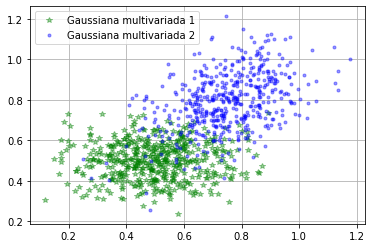

In [ ]:
mean1 = [0.5, 0.5]
cov1 = [[0.02, 0], [0, 0.01]]
x1 = np.random.multivariate_normal(mean1, cov1, 500)
y1 = np.zeros((500,1), dtype='uint')

mean2 = [0.75, 0.8]
cov2 = [[0.02, 0.01], [0.01, 0.02]]
x2 = np.random.multivariate_normal(mean2, cov2, 500)
y2 = np.ones((500,1), dtype='uint')

x, y = np.concatenate((x1, x2), axis=0), np.concatenate((y1, y2), axis=0)

plt.plot(x1[:,0], x1[:,1], '*', label='Gaussiana multivariada 1', c='g', alpha=0.4)
plt.plot(x2[:,0], x2[:,1], '.', label='Gaussiana multivariada 2', c='b', alpha=0.4)
plt.legend()
plt.grid(True)
plt.show()

**1.1** En este paso construiremos la red neuronal perceptron multicapa que utilizaremos para clasificar los datos provenientes de las dos Gaussianas multivariadas. Para esto utilizaremos las siguientes especificaciones: 1. Una capa oculta de 8 neuronas y una capa de salida de 1 neurona. 2. Función de activación sigmoide. 3. Función de divergencia de entropía cruzada binaria.

In [ ]:
class PerceptronMulticapa(object):
    def __init__(self, inp_dim, hidden_dim, out_dim, learning_r, epochs):
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.learning_r = learning_r
        self.epochs = epochs
        samples, features = inp_dim
        self.theta1 = tf.Variable(tf.random.normal([features+1,self.hidden_dim], dtype= tf.float64), name = "Theta1")
        self.theta2 = tf.Variable(tf.random.normal([self.hidden_dim+1,self.out_dim], dtype= tf.float64), name = "Theta2")

    def forward(self, x):
        samples = x.shape[0]
        self.bias1 = tf.constant(1, dtype=tf.float64, shape=(samples,1), name='bias1')
        self.bias2 = tf.constant(1, dtype=tf.float64, shape=(samples,1), name='bias2')
        a0 = tf.concat([self.bias1,x],1, name='a0')
        z1 = tf.matmul(a0,self.theta1, name='z1')
        a1 = tf.concat([self.bias2,tf.sigmoid(z1)],1,name='a1')
        z2 = tf.matmul(a1,self.theta2, name='z2')
        a2 = tf.sigmoid(z2, name='a2')
        return a2

    def backward(self, x_train, y_train, x_val, y_val):
        theta1_hist, theta2_hist = [], []
        save_loss_train, save_loss_val, save_accuracy_train, save_accuracy_val = [], [], [], []
        for epoch in range(self.epochs):
            learning_rate = self.learning_r
            with tf.GradientTape() as t:
                loss_train = PerceptronMulticapa.loss_train(y_train, self.predict(x_train))
                save_loss_train.append(PerceptronMulticapa.loss_train(y_train, self.predict(x_train)).numpy())
                accuracy_train = PerceptronMulticapa.accuracy(y_train, self.predict(x_train), loss_train)
                save_accuracy_train.append(PerceptronMulticapa.accuracy(y_train, self.predict(x_train), loss_train))
                loss_val = PerceptronMulticapa.loss_train(y_val, self.predict(x_val))
                save_loss_val.append(PerceptronMulticapa.loss_train(y_val, self.predict(x_val)).numpy())
                accuracy_val = PerceptronMulticapa.accuracy(y_val, self.predict(x_val), loss_train)
                save_accuracy_val.append(PerceptronMulticapa.accuracy(y_val, self.predict(x_val), loss_train))
            dThe1, dThe2 = t.gradient(loss_train, [self.theta1, self.theta2])
            self.theta1.assign_sub(learning_rate * dThe1)
            self.theta2.assign_sub(learning_rate * dThe2)
            if np.isnan(loss_train) == True:
                if epoch % 100==0:
                  print('Epoch %2d: learning_rate=%2.5f, loss_train=%2.5f' % (epoch, learning_rate, loss_train))
            elif epoch % 100 == 0:
                theta1_hist.append(self.theta1.numpy())
                theta2_hist.append(self.theta2.numpy())
                print('Epoch %2d: learning_rate=%2.5f, loss_train=%2.5f, loss_val=%2.5f, accuracy_train=%2.5f, accuracy_val=%2.5f' % (epoch, learning_rate, loss_train, loss_val, accuracy_train, accuracy_val))
        return  save_loss_train, save_loss_val, save_accuracy_train, save_accuracy_val

    def predict(self, x):
        return self.forward(x)
    
    def loss_train(target_y, predicted_y):
        return  -tf.reduce_sum(target_y*tf.math.log(predicted_y)+(1-target_y)*tf.math.log(1-predicted_y), axis = 0, name='Cost_function')

    def accuracy(y_observed, y_foretold, loss_train):
        if np.isnan(loss_train) == False:
          y_foretold = np.round(y_foretold)
          matrix = confusion_matrix(y_observed, y_foretold)
          ac = accuracy_score(y_observed, y_foretold)
          return ac


**1.2** Utilizando los datos proveídos construya los un conjunto de entrenamiento(60%), validación (20%) y test (20%). Asegurese de que al menos en el conjunto de entrenamento los datos se encuentren aleatorizados respecto a su clase. (3 pts.)

[[0.86532226 0.7146549  1.        ]
 [0.8212016  0.65624421 1.        ]
 [0.40475775 0.59874175 0.        ]
 ...
 [0.827292   1.00569981 1.        ]
 [0.24879179 0.50861673 1.        ]
 [0.90822591 0.70544479 1.        ]]
(600, 3)
(200, 3)
(200, 3)


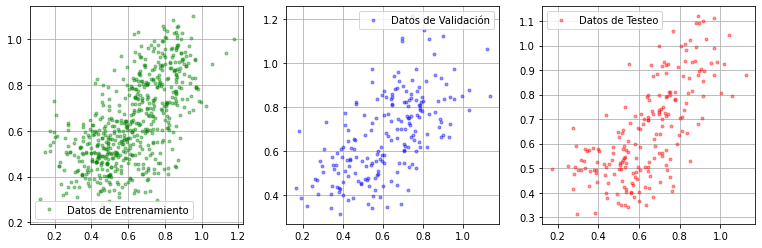

In [ ]:
join = np.concatenate((x,y), axis=1)
np.random.seed(0)
np.random.shuffle(join) 
print(join)

train, validate, test = np.split(join, [int(.6*len(join)), int(.8*len(join))])
print(train.shape)
print(validate.shape)
print(test.shape)

x_train = train[:,[0,1]]
y_train = train[:,[2]]

x_val = validate[:,[0,1]]
y_val = validate[:,[2]]

x_test = test[:,[0,1]]
y_test = test[:,[2]]

plt.figure(figsize=(13, 4))

ax = plt.subplot(1, 3, 1)
plt.plot(x_train[:,0], x_train[:,1], '.', label='Datos de Entrenamiento', c='g', alpha=0.4)
plt.legend()
plt.grid(True)

ax = plt.subplot(1, 3, 2)
plt.plot(x_val[:,0], x_val[:,1], '.', label='Datos de Validación', c='b', alpha=0.4)
plt.legend()
plt.grid(True)

ax = plt.subplot(1, 3, 3)
plt.plot(x_test[:,0], x_test[:,1], '.', label='Datos de Testeo', c='r', alpha=0.4)
plt.legend()
plt.grid(True)

plt.show()

**1.3** Entrene la red neuronal construida en el primer paso, variando el learning rate en cada entrenamiento. Se pide probar con las siguientes alternativas: 1, 0.1, 0.01, 0.001, 0.0001, 0.00001. Por cada entrenamiento utilize al menos 300 épocas y muestre la curvas de aprendizaje para accuracy y loss. Las curvas deben ser construidas utilizando el conjunto de entrenamiento y de validación. 

¿Cuál es la mejor alternativa de learning rate para el problema propuesto? ¿Por qué? (7 pts.)

In [ ]:
ln_rate = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for i in range(len(ln_rate)):
    print("With learning rate = %2.5f"% (ln_rate[i]))  
    Modelo = PerceptronMulticapa(inp_dim=x.shape, hidden_dim=8, out_dim=1, learning_r=ln_rate[i], epochs=1500)
    if i == 0:
        lr1 = Modelo.backward(x_train, y_train, x_val, y_val)
    elif i == 1:
        lr2 = Modelo.backward(x_train, y_train, x_val, y_val)
    elif i == 2:
        lr3 = Modelo.backward(x_train, y_train, x_val, y_val)
    elif i == 3:
        lr4 = Modelo.backward(x_train, y_train, x_val, y_val)
    elif i == 4:
        lr5 = Modelo.backward(x_train, y_train, x_val, y_val)
    elif i == 5:
        lr6 = Modelo.backward(x_train, y_train, x_val, y_val)


With learning rate = 1.00000
Epoch  0: learning_rate=1.00000, loss_train=958.93995, loss_val=356.57767, accuracy_train=0.51333, accuracy_val=0.45500
Epoch 100: learning_rate=1.00000, loss_train=nan
Epoch 200: learning_rate=1.00000, loss_train=nan
Epoch 300: learning_rate=1.00000, loss_train=nan
Epoch 400: learning_rate=1.00000, loss_train=nan
Epoch 500: learning_rate=1.00000, loss_train=nan
Epoch 600: learning_rate=1.00000, loss_train=nan
Epoch 700: learning_rate=1.00000, loss_train=nan
Epoch 800: learning_rate=1.00000, loss_train=nan
Epoch 900: learning_rate=1.00000, loss_train=nan
Epoch 1000: learning_rate=1.00000, loss_train=nan
Epoch 1100: learning_rate=1.00000, loss_train=nan
Epoch 1200: learning_rate=1.00000, loss_train=nan
Epoch 1300: learning_rate=1.00000, loss_train=nan
Epoch 1400: learning_rate=1.00000, loss_train=nan
With learning rate = 0.10000
Epoch  0: learning_rate=0.10000, loss_train=1156.38505, loss_val=429.40925, accuracy_train=0.51333, accuracy_val=0.45500
Epoch 100:

**Curvas de aprendizaje para loss**

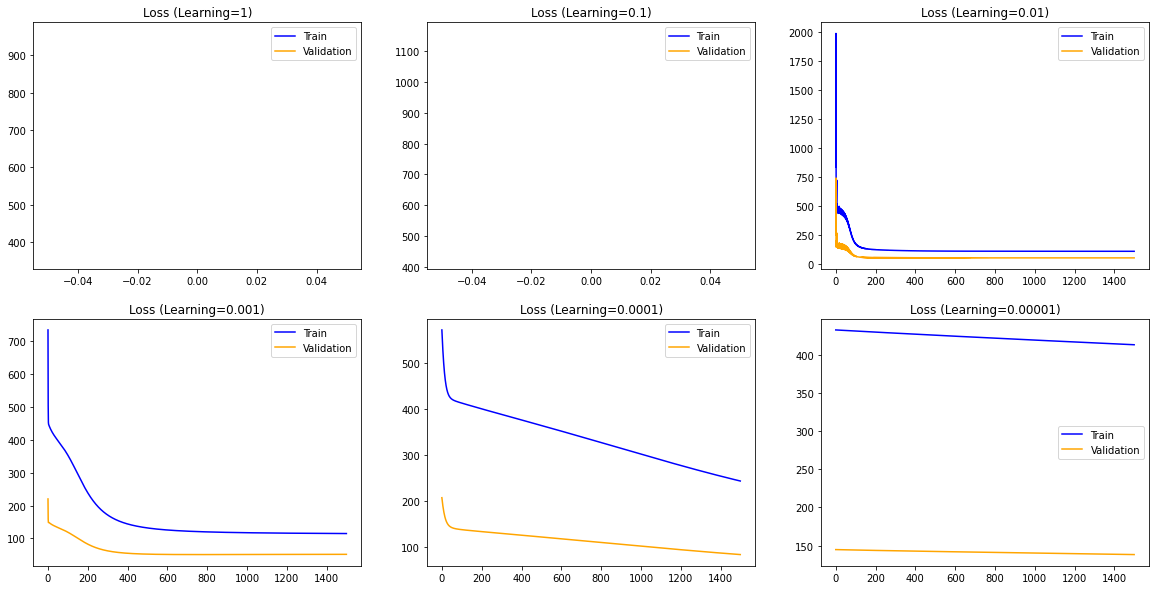

In [ ]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2, 3, 1)
plt.plot(lr1[0], "b-", label="Train")
plt.plot(lr1[1], '-', color="orange", label="Validation")
plt.title("Loss (Learning=1)")
plt.grid(False)
plt.legend()

ax1 = plt.subplot(2, 3, 2)
plt.plot(lr2[0], "b-", label="Train")
plt.plot(lr2[1], '-', color="orange", label="Validation")
plt.title("Loss (Learning=0.1)")
plt.grid(False)
plt.legend()

ax1 = plt.subplot(2, 3, 3)
plt.plot(lr3[0],"b-", label="Train")
plt.plot(lr3[1], '-', color="orange", label="Validation")
plt.title("Loss (Learning=0.01)")
plt.grid(False)
plt.legend()

ax1 = plt.subplot(2, 3, 4)
plt.plot(lr4[0],"b-", label="Train")
plt.plot(lr4[1], '-', color="orange", label="Validation")
plt.title("Loss (Learning=0.001)")
plt.grid(False)
plt.legend()

ax1 = plt.subplot(2, 3, 5)
plt.plot(lr5[0],"b-", label="Train")
plt.plot(lr5[1], '-', color="orange", label="Validation")
plt.title("Loss (Learning=0.0001)")
plt.grid(False)
plt.legend()

ax1 = plt.subplot(2, 3, 6)
plt.plot(lr6[0],"b-", label="Train")
plt.plot(lr6[1], '-', color="orange", label="Validation")
plt.title("Loss (Learning=0.00001)")
plt.grid(False)
plt.legend()

plt.show()

**Curvas de aprendizaje para accuracy**

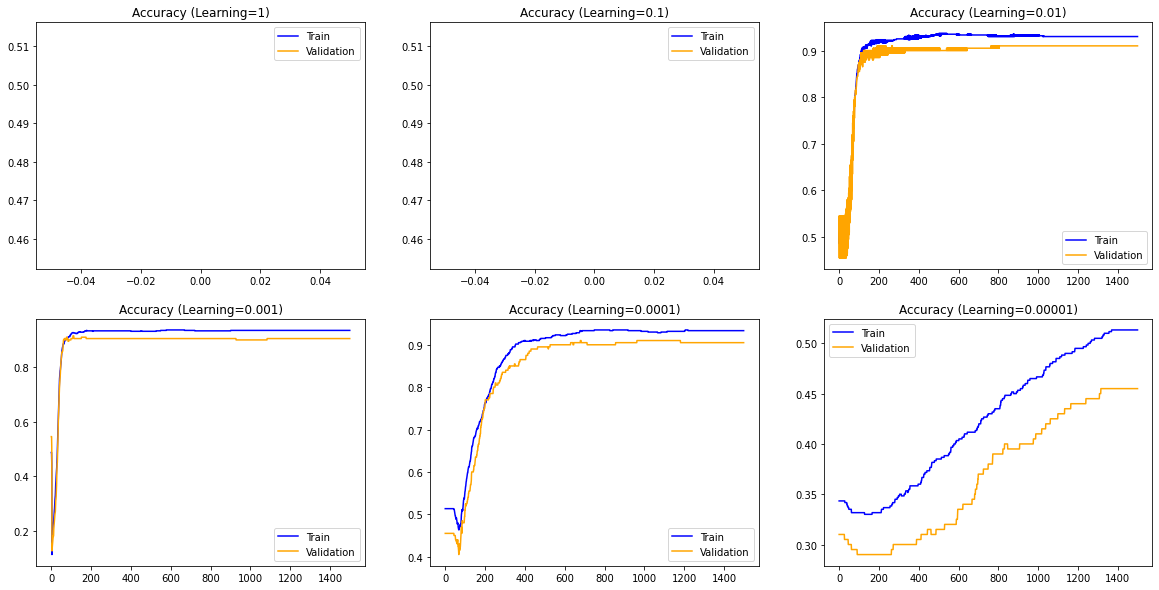

In [ ]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2, 3, 1)
plt.plot(lr1[2], "b-", label="Train")
plt.plot(lr1[3], '-', color="orange", label="Validation")
plt.title("Accuracy (Learning=1)")
plt.grid(False)
plt.legend()

ax1 = plt.subplot(2, 3, 2)
plt.plot(lr2[2], "b-", label="Train")
plt.plot(lr2[3], '-', color="orange", label="Validation")
plt.title("Accuracy (Learning=0.1)")
plt.grid(False)
plt.legend()

ax1 = plt.subplot(2, 3, 3)
plt.plot(lr3[2],"b-", label="Train")
plt.plot(lr3[3], '-', color="orange", label="Validation")
plt.title("Accuracy (Learning=0.01)")
plt.grid(False)
plt.legend()

ax1 = plt.subplot(2, 3, 4)
plt.plot(lr4[2],"b-", label="Train")
plt.plot(lr4[3], '-', color="orange", label="Validation")
plt.title("Accuracy (Learning=0.001)")
plt.grid(False)
plt.legend()

ax1 = plt.subplot(2, 3, 5)
plt.plot(lr5[2],"b-", label="Train")
plt.plot(lr5[3], '-', color="orange", label="Validation")
plt.title("Accuracy (Learning=0.0001)")
plt.grid(False)
plt.legend()

ax1 = plt.subplot(2, 3, 6)
plt.plot(lr6[2],"b-", label="Train")
plt.plot(lr6[3], '-', color="orange", label="Validation")
plt.title("Accuracy (Learning=0.00001)")
plt.grid(False)
plt.legend()

plt.show()

¿Cuál es la mejor alternativa de learning rate para el problema propuesto? ¿Por qué?

La mejor alternativa de learning rate para este problema es un learning rate = 0.01 o bien un learning rate = 0.001, ya que como se puede observar en las iteraciones la funcion de perdida para los datos de entrenamiento y validacion tienen una brecha no tan lejana, lo que indica que tan bien esta generalizando el modelo. De esta misma forma, el accuracy de ambos learning rate es elevado teniendo un 93% aprox. para los datos de entrenamiento y un 91% aprox. para los datos de validación. Además, de la curvas de aprendizaje para el loss se puede ver que en general muestra un buen ajuste, ya que la gráfica de la pérdida de entrenamiento disminuye hasta un punto de estabilidad y la gráfica de la pérdida de validación también disminuye hasta un punto de estabilidad y tiene una pequeña brecha con la pérdida de entrenamiento. 

# Pregunta 2: Entendiendo las operaciones convolucionales

En este apartado vamos a investigar de manera gráfica cuál es el resultado de una operación de convolución, que corresponde a la capacidad de una red convolucional de generar representaciones a partir de una imágen.

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


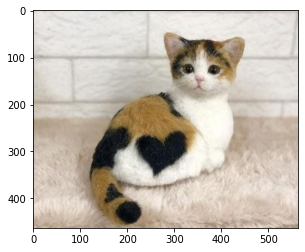

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=564x463 at 0x7FEB1872BB38>


In [ ]:
from __future__ import division  
from PIL import Image
from google.colab import files   
from google.colab import drive   
from scipy import ndimage

import numpy as np                
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2 as cv
import cv2

drive.mount('/content/drive')

cat = Image.open('/content/drive/My Drive/Colab Notebooks/cute_cat.jpeg')
plt.imshow(cat)
plt.show()
print(cat)

**2.1** Cargue la imagen anterior como una matriz NumPy. Luego normalice la imagen de tal forma que sus valores estén dentro del rango -0.5, 0.5 

(3 pts.)

In [ ]:
#Matriz numpy de la imagen en modo RGB.
b = np.asarray(cat)
print(b)
print('')
print(b.shape)
print('')

[[[210 206 203]
  [213 209 206]
  [217 213 210]
  ...
  [206 201 197]
  [205 200 196]
  [205 200 196]]

 [[213 209 206]
  [215 211 208]
  [217 213 210]
  ...
  [203 198 194]
  [202 197 193]
  [202 197 193]]

 [[218 214 211]
  [218 214 211]
  [218 214 211]
  ...
  [201 196 192]
  [200 195 191]
  [199 194 190]]

 ...

 [[207 186 167]
  [207 186 167]
  [205 184 165]
  ...
  [166 145 124]
  [169 148 127]
  [169 148 127]]

 [[201 180 161]
  [205 184 165]
  [206 185 166]
  ...
  [172 151 130]
  [172 151 130]
  [170 149 128]]

 [[196 175 156]
  [201 180 161]
  [205 184 165]
  ...
  [183 161 140]
  [181 159 138]
  [178 156 135]]]

(463, 564, 3)



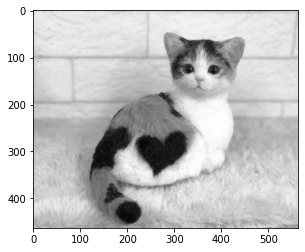

[[207 210 214 ... 202 201 201]
 [210 212 214 ... 199 198 198]
 [215 215 215 ... 197 196 195]
 ...
 [190 190 188 ... 149 152 152]
 [184 188 189 ... 155 155 153]
 [179 184 188 ... 165 163 160]]

(463, 564)

[[ 0.1171875  0.140625   0.171875  ...  0.078125   0.0703125  0.0703125]
 [ 0.140625   0.15625    0.171875  ...  0.0546875  0.046875   0.046875 ]
 [ 0.1796875  0.1796875  0.1796875 ...  0.0390625  0.03125    0.0234375]
 ...
 [-0.015625  -0.015625  -0.03125   ... -0.3359375 -0.3125    -0.3125   ]
 [-0.0625    -0.03125   -0.0234375 ... -0.2890625 -0.2890625 -0.3046875]
 [-0.1015625 -0.0625    -0.03125   ... -0.2109375 -0.2265625 -0.25     ]]

(463, 564)


In [ ]:
#Se pasa la imagen a gris, ya que se trabajara en escala de grises 
cat_gray =cat.convert('L')
plt.imshow(cat_gray, cmap='gray')
plt.show()

#Se vuelve a obtener la matriz numpy, pero para la escala de grises de la imagen
a = np.asarray(cat_gray)
print(a)
print('')
print(a.shape)
print('')

#Se normaliza la imagen
def normalize(x):
  return (x.astype(float) - 128) / 128

a_norm = normalize(a)
a_norm_intv = a_norm-0.5
print(a_norm_intv)
print('')
print(a_norm_intv.shape)

**2.2** Elija dos kernel de tamaño 3x3 (ej. border detection, sharpen, box blur kernels, etc. Estos los puede encontrar [acá](https://en.wikipedia.org/wiki/Kernel_(image_processing))) y convolucione la imagen con cada uno de ellos. Para esto puede ocupar su propia función de convolución o utilzar la función [scipy.ndimage.filters.convolve](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.filters.convolve.html), utiizando borde constante.

(6 pts.)

In [ ]:
#Kernel of border detection
h1 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

#Kernel of sharpen
h2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

#Convolucion de la imagen con cada kernel
conv1 = ndimage.convolve(a_norm_intv, h1, mode='constant', cval=0.0)
conv2 = ndimage.convolve(a_norm_intv, h2, mode='constant', cval=0.0)
print(conv1)
print(conv2)

[[ 0.5        0.3671875  0.515625  ...  0.296875   0.265625   0.3984375]
 [ 0.3515625 -0.03125   -0.0234375 ... -0.0390625 -0.0390625  0.1328125]
 [ 0.53125   -0.015625  -0.0234375 ... -0.0390625 -0.015625   0.0390625]
 ...
 [ 0.015625   0.1328125  0.0390625 ... -0.2578125 -0.09375   -1.015625 ]
 [-0.2734375  0.09375    0.078125  ... -0.09375   -0.0703125 -1.046875 ]
 [-0.65625   -0.25      -0.078125  ... -0.390625  -0.46875   -1.1796875]]
[[ 0.3046875  0.2578125  0.34375   ...  0.1796875  0.15625    0.234375 ]
 [ 0.25       0.1484375  0.1640625 ...  0.0390625  0.03125    0.09375  ]
 [ 0.359375   0.171875   0.171875  ...  0.0234375  0.03125    0.03125  ]
 ...
 [ 0.         0.03125   -0.015625  ... -0.4296875 -0.3359375 -0.65625  ]
 [-0.1640625  0.0078125  0.0078125 ... -0.3125    -0.3125    -0.671875 ]
 [-0.3828125 -0.1484375 -0.046875  ... -0.34375   -0.3828125 -0.71875  ]]


**2.3** Una vez convolucionada la imagen, convierta a cero los valores menores a cero. Para esto puede usar la función [np.clip](https://numpy.org/doc/1.18/reference/generated/numpy.clip.html).

(2 pts)

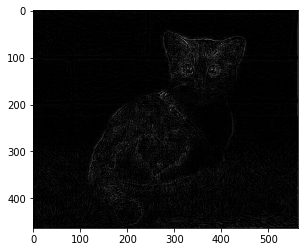

(463, 564)


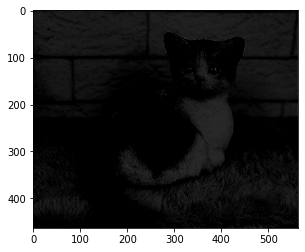

(463, 564)


In [ ]:
conv1_conv = np.clip(conv1, 0, 3)
conv2_conv = np.clip(conv2, 0, 3)

plt.imshow(conv1_conv, cmap="gray")
plt.show()
print(conv1_conv.shape)
plt.imshow(conv2_conv, cmap="gray")
plt.show()
print(conv2_conv.shape)

**2.4** Implemente por su cuenta la operación de agregación estadística Max-Pooling. Para esto utilice kernel_size=4 y stride=4.

(6 pts.)

In [ ]:
# Se agrego filas de 0 para que se pueda aplicar el max pooling
conv1_conv.resize((468,564))
conv2_conv.resize((468,564))
print(conv1_conv.shape)

(468, 564)


In [ ]:
#Funcion max pooling
def max_pooling(a, kernel_size):
  m, n = a.shape
  stride = kernel_size
  kernel_h = kernel_size
  kernel_w = kernel_size

  max_pool = None
  height = 1 + (m-kernel_h)//stride
  width = 1 + (n-kernel_w)//stride
  max_pool = np.zeros((height,width))
  
  for x in range(0,m,stride):
    for y in range(0,n,stride):
      
      max_pool[x//stride,y//stride] = np.max(a[x:x+kernel_h,y:y+kernel_w])

  return max_pool

conv1_pool = max_pooling(conv1_conv, 4)
conv2_pool = max_pooling(conv2_conv, 4)
print(conv1_pool.shape)
print("")
print(conv1_pool)
print("")
print(conv2_pool.shape)
print("")
print(conv2_pool)

(117, 141)

[[0.6953125 0.703125  0.6015625 ... 0.5078125 0.5       0.3984375]
 [0.8515625 0.0625    0.15625   ... 0.03125   0.0625    0.015625 ]
 [0.9921875 0.109375  0.0625    ... 0.171875  0.265625  0.0859375]
 ...
 [0.171875  0.40625   0.1484375 ... 0.4375    0.34375   0.3671875]
 [0.1328125 0.2578125 0.03125   ... 0.296875  0.1796875 0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]

(117, 141)

[[0.453125  0.453125  0.40625   ... 0.3203125 0.3046875 0.234375 ]
 [0.5625    0.2890625 0.359375  ... 0.2109375 0.203125  0.03125  ]
 [0.6640625 0.34375   0.34375   ... 0.3203125 0.359375  0.1015625]
 ...
 [0.0859375 0.1328125 0.        ... 0.        0.        0.       ]
 [0.03125   0.03125   0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]


**2.5** Muestre los resultados de las operaciones realizadas. ¿Qué puede decir acerca de ellos? ¿Cómo cree que estas operaciones pueden ser de utilidad para una red neuronal a la hora de realizar una tarea de clasificación?

(3 pts.)

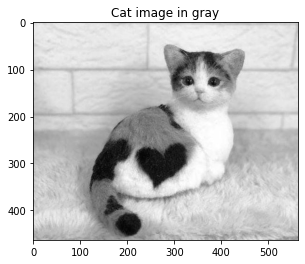

Matriz numpy de la imagen en escala de grises (la matriz numpy en escala RGB esta en el punto 2.1):
[[207 210 214 ... 202 201 201]
 [210 212 214 ... 199 198 198]
 [215 215 215 ... 197 196 195]
 ...
 [190 190 188 ... 149 152 152]
 [184 188 189 ... 155 155 153]
 [179 184 188 ... 165 163 160]]

(463, 564)

Valores normalizados de la matriz de la imagen:
[[ 0.1171875  0.140625   0.171875  ...  0.078125   0.0703125  0.0703125]
 [ 0.140625   0.15625    0.171875  ...  0.0546875  0.046875   0.046875 ]
 [ 0.1796875  0.1796875  0.1796875 ...  0.0390625  0.03125    0.0234375]
 ...
 [-0.015625  -0.015625  -0.03125   ... -0.3359375 -0.3125    -0.3125   ]
 [-0.0625    -0.03125   -0.0234375 ... -0.2890625 -0.2890625 -0.3046875]
 [-0.1015625 -0.0625    -0.03125   ... -0.2109375 -0.2265625 -0.25     ]]

(463, 564)

Convolucion con el kernel of border detection:
[[ 0.5        0.3671875  0.515625  ...  0.296875   0.265625   0.3984375]
 [ 0.3515625 -0.03125   -0.0234375 ... -0.0390625 -0.0390625  0.132812

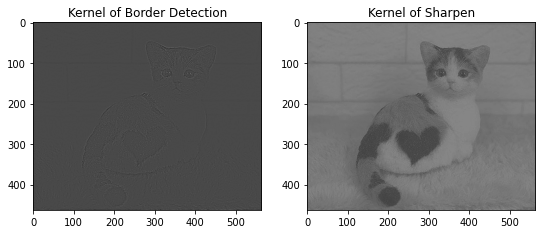


Imagenes con valores positivos:


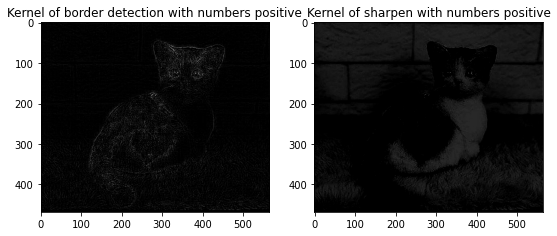

Resultados del max pooling para la convolucion de la imagen con el border deteccion y sharpe (por separado):
(117, 141)

[[0.6953125 0.703125  0.6015625 ... 0.5078125 0.5       0.3984375]
 [0.8515625 0.0625    0.15625   ... 0.03125   0.0625    0.015625 ]
 [0.9921875 0.109375  0.0625    ... 0.171875  0.265625  0.0859375]
 ...
 [0.171875  0.40625   0.1484375 ... 0.4375    0.34375   0.3671875]
 [0.1328125 0.2578125 0.03125   ... 0.296875  0.1796875 0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]

(117, 141)

[[0.453125  0.453125  0.40625   ... 0.3203125 0.3046875 0.234375 ]
 [0.5625    0.2890625 0.359375  ... 0.2109375 0.203125  0.03125  ]
 [0.6640625 0.34375   0.34375   ... 0.3203125 0.359375  0.1015625]
 ...
 [0.0859375 0.1328125 0.        ... 0.        0.        0.       ]
 [0.03125   0.03125   0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]


In [ ]:
#Se paso la imagen a escala de grises, ya que se trabajara de esta forma.
plt.imshow(cat_gray, cmap='gray')
plt.title("Cat image in gray")
plt.show()

#Se obtuvo la matriz numpy de la imagen en escala de grises.
print("Matriz numpy de la imagen en escala de grises (la matriz numpy en escala RGB esta en el punto 2.1):")
print(a)
print('')
print(a.shape)
print('')

#Se normalizo la imagen con valores entre -0.5 y 0.5
print("Valores normalizados de la matriz de la imagen:")
print(a_norm_intv)
print('')
print(a_norm_intv.shape)
print('')

#Se le aplico una convolucion a la imagen con un filtro 3x3 border detection y un filtro 3x3 sharpen
print("Convolucion con el kernel of border detection:")
print(conv1)
print("")
print("Convolucion con el kernel of sharpen:")
print(conv2)

fig = plt.figure(figsize=(9,9))
fig.add_subplot(1,2,1)
plt.imshow(conv1, cmap="gray")
plt.title("Kernel of Border Detection")

fig.add_subplot(1,2,2)
plt.imshow(conv2, cmap="gray")
plt.title("Kernel of Sharpen")
plt.show()
print("")

#se convirtieron los valores menores a cero en cero y se muestra nuevamente la imagen
print("Imagenes con valores positivos:")
fig1 = plt.figure(figsize=(9,9))
fig1.add_subplot(1,2,1)
plt.imshow(conv1_conv, cmap="gray")
plt.title("Kernel of border detection with numbers positive")

fig1.add_subplot(1,2,2)
plt.imshow(conv2_conv, cmap="gray")
plt.title("Kernel of sharpen with numbers positive")
plt.show()

#Se muestran los resulados de la aplicacion del Max Pooling
print("Resultados del max pooling para la convolucion de la imagen con el border deteccion y sharpe (por separado):")
print(conv1_pool.shape)
print("")
print(conv1_pool)
print("")
print(conv2_pool.shape)
print("")
print(conv2_pool)

¿Qué puede decir acerca de ellos? ¿Cómo cree que estas operaciones pueden ser de utilidad para una red neuronal a la hora de realizar una tarea de clasificación?

De los resultados obtenidos se pueden observar los patrones que se detectaron de una imagen de entrada mediante un filtro, en este caso, se usó el kernel de detección de bordes y sharpen. Cada filtro se especializa en extraer diferentes características de la imagen, como bien lo dicen sus nombres. Posterior a esto, se aplicó el max pooling, en donde se puede observar la reducción de la cantidad de datos y extracción de los datos más representativos de la matriz. Con la repetición de estos procedimientos el tamaño de las imágenes resultantes se ira haciendo cada vez más pequeño. Asimismo, a medida que se ingrese más profundo en la red se estaran extrayendo más características de las imágenes de entrada y estas serán cada vez más complejas. De esta manera, lo que hace la red convolucional es detectar una estructura de la manera más rápida posible mediante el aprendizaje de alguna característica que permita distinguir fácilmente el problema y no tener que memorizar toda la secuencia de datos, lo que permite una red más eficiente, ya que tendrá que calcular menos pesos. De esta forma se simplifica el problema, lo que implica un costo computacional más bajo para cuando los datos lleguen a la red neuronal. La clasificaciones en la red neuronal para grandes datos de entrada serán mucho más eficientes, ya que la convolución "simplifica" los datos. En cambio, si una gran volumen de datos se ingresan directamente a la red neuronal para su posterior clasificación, se tendrá un costo de computacional más alto. Por esto, para un problema de clasificación en donde se puedan extraer características representativas es recomendable ocupar previamente una red convolucional.  


# Pregunta 3: Construyendo una Red Convolucional

The Street View House Numbers  [(SVHN)](https://ufldl.stanford.edu/housenumbers/) 1 es un conocido dataset, comunmente utilizado como benchmark para probar y comparar modelos de Machine Learning. Este dataset contiene imágenes de números de casa vistos desde la calle, los cuales se encuentran etiquetados y dicha etiqueta se asocia al dígito que se encuentra al centro de la imagen.

<img src="http://ufldl.stanford.edu/housenumbers/32x32eg.png" alt="drawing" width="400"/>


Los datos se encuentran públicamente disponibles a continuación:
1. [train set](http://ufldl.stanford.edu/housenumbers/train_32x32.mat)
2. [test set](http://ufldl.stanford.edu/housenumbers/test_32x32.mat)


[1] Netzer, Y., Wang, T., Coates, A., Bissacco, A., Wu, B., Y Ng, A.: Reading Digits in Natural Images with Unsupervised Feature Learning. NIPS (2011)

**3.1** Cargue las imagenes y etiquetas del set de entrenamiento y test como matrices NumPy. Las etiquetas van del número del '1' al '10', donde la décima etiqueta se asocia al valor 0. Cambie el valor de la etiqueta '10', para que cada etiqueta quede asociada al dígito que representa. Finalmente, grafique 9 imágenes del conjunto de entrenamiento.

(3 pts.)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(32, 32, 3, 73257)
(73257, 1)

(32, 32, 3, 26032)
(26032, 1)


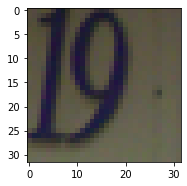

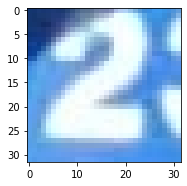

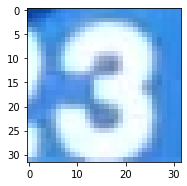

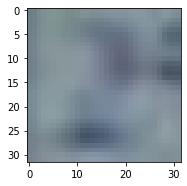

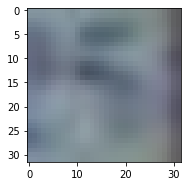

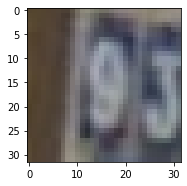

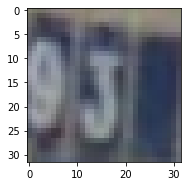

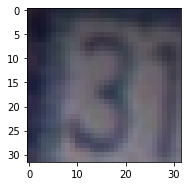

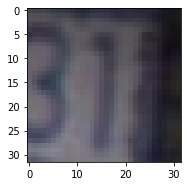

In [ ]:
from __future__ import division  
from google.colab import drive
from google.colab import files
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.python.keras import optimizers

from keras.models import Sequential
from keras.utils import np_utils

import numpy as np        
import pandas as pd        
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.io as sc
import keras

#Se cargan los archivos y se asignan los conjuntos de entrenamiento y testeo
drive.mount('/content/drive')

datos_test = sc.loadmat('/content/drive/My Drive/Colab Notebooks/test_32x32.mat')
datos_train = sc.loadmat('/content/drive/My Drive/Colab Notebooks/train_32x32.mat')

print(datos_test.keys())
print(datos_train.keys())

x_train1 = datos_train['X']
y_train1 = datos_train['y']
x_test1 = datos_test['X']
y_test1 = datos_test['y']
print(x_train1.shape)
print(y_train1.shape)
print("")
print(x_test1.shape)
print(y_test1.shape)

#Cambia el valor de la etiqueta
y_train1[y_train1==10] = 0
y_test1[y_test1==10] = 0

def image(x):
  for i in list(range(1,10)):
    fig2 = plt.figure(figsize=(30, 30))
    ax = fig2.add_subplot(9, 1, i)
    plt.imshow(x_train1[:,:,:,i])
  return plt.show()

image(x_train1)

**3.2** Para terminar el preprocesamiento de los datos, se pide que las etiquetas se presenten como variables categóricas. Esto es, para la etiqueta:

0 = [1, 0, ... , 0]
1 = [0, 1, ... , 0]
...
N = [0, 0, ... , 1]

Además, se pide seleccionar un conjunto de validación para poder monitorear el sobreajuste del modelo sobre los datos de entrenamiento. Se pide que un 20% de los datos de entrenamiento sean utilizados para validación.

(3 pts.)

In [ ]:
#Etiquetas a variables categoricas
y_train1 = np_utils.to_categorical(y_train1)
y_test1 = np_utils.to_categorical(y_test1)

print(y_train1.shape)
print(y_train1)
print("")
print(y_test1.shape)
print(y_test1)
print("")

#Transponer las dimensiones para el entrenamiento
x_train1 = x_train1.transpose((3, 0, 1, 2))
x_test1 = x_test1.transpose((3, 0, 1, 2))

x_train1, x_val, y_train1, y_val = train_test_split(x_train1, y_train1, test_size=0.2, random_state=7)

print(y_train1.shape)
print(y_val.shape) 
print(y_test1.shape)

(73257, 10)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]

(26032, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]

(58605, 10)
(14652, 10)
(26032, 10)


**3.3** Para construir red convolucional, se utilizará una modificación la famosa arquitectura arquitectura AlexNet, propuesta por Alex Krizhevsky 2(http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

Se pide especificamente construir una red convoucional con la siguiente arquitectura:

| Layer  | Operation|  Kernel |  Stride |  Activation | Maxpooling (stride) | Dropout (prob) |
|---|---|---|---|---|---|---|
|  1 | Convolución (32)  |  (3,3) |  1 |  ReLU |  No | No |
|  2 |  Convolución (32) | (3,3)  |  1 | ReLU  |  Yes (2,2) | No |
|  3 |  Convolución (64) | (3,3)  |  1 | ReLU  |  No | No |
|  4 |  Convolución (64) | (3,3)  |  1 | ReLU  |  Yes (2,2) | Yes(0.25) |
|  5 |  Densa (512) | -  | - | ReLU  | No | Yes(0.5) |
|  5 |  Densa (10) | -  | - | Softmax  | No | No |

Calcule el número de parámetros a dicha arquitectura.

[2] Krizhevsky, A., Sutskever, I., Hinton, G.: ImageNet Classification with Deep Convolutional Neural Networks. NIPS (2012)

(8 pts.)


In [ ]:
#Modelo de red convolucional
cnn = Sequential()
cnn.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', input_shape=(32,32,3)))
cnn.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu'))
cnn.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(10, activation='softmax')) 

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)         

**3.4** Entrene esta red neuronal utilizando la función de costos correspondiente y las siguientes consideraciones:

> 1.- Optimizador Adam (lr=0.0001)

> 2.- Batch size = 64

> 3.- Número de epocas = 10

OBS: debe tener en cuenta que el proceso de entrenamiento CPU puede demorar algunas horas. Si dispone de GPU (o utiliza coblab), puede acelerar este proceso y demorarse incluso minutos

(3 pts.)

In [ ]:
#Entrenamiento de la red neuronal
opt = keras.optimizers.Adam(learning_rate=0.0001)
cnn.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
fit = cnn.fit(x_train1, y_train1, batch_size=64, epochs=10, verbose=1, validation_data=(x_val,y_val))

Train on 58605 samples, validate on 14652 samples
Epoch 1/10
58605/58605 [==============================] - 202s 3ms/step - loss: 1.8933 - accuracy: 0.4648 - val_loss: 0.7354 - val_accuracy: 0.7920
Epoch 2/10
58605/58605 [==============================] - 202s 3ms/step - loss: 0.8618 - accuracy: 0.7389 - val_loss: 0.5617 - val_accuracy: 0.8418
Epoch 3/10
58605/58605 [==============================] - 202s 3ms/step - loss: 0.7038 - accuracy: 0.7894 - val_loss: 0.4841 - val_accuracy: 0.8596
Epoch 4/10
58605/58605 [==============================] - 202s 3ms/step - loss: 0.6100 - accuracy: 0.8181 - val_loss: 0.4368 - val_accuracy: 0.8761
Epoch 5/10
58605/58605 [==============================] - 206s 4ms/step - loss: 0.5483 - accuracy: 0.8370 - val_loss: 0.4162 - val_accuracy: 0.8848
Epoch 6/10
58605/58605 [==============================] - 202s 3ms/step - loss: 0.4901 - accuracy: 0.8541 - val_loss: 0.3850 - val_accuracy: 0.8934
Epoch 7/10
58605/58605 [==============================] - 201s

**3.5** Grafique dos curvas de aprendizaje, donde en el eje x se muestre el número de épocas y en el eje y se muestre la función de pérdida / accuracy respectivamente. Este gráfico debe contener los valores para el conjunto de entrenamiento, validación y el resultado final medido sobre el conjunto de test.

(3 pts.)

26032/26032 [==============================] - 22s 847us/step
Loss:0.37873 Accuracy:0.89628

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])



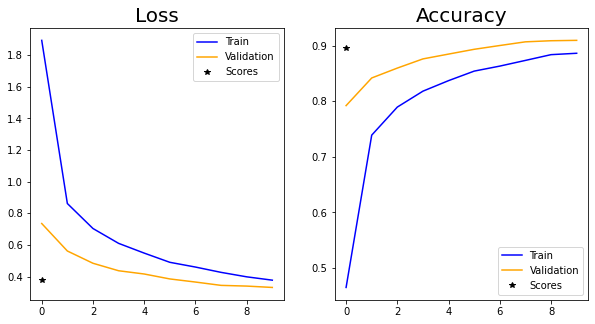

In [ ]:
#Resultado final sobre el conjunto de test
scores = cnn.evaluate(x_test1, y_test1, verbose = 1)
print("Loss:%2.5f Accuracy:%2.5f"%(scores[0], scores[1]))
print("")

#Graficas de las curvas de aprendizaje de la funcion de perdida y del accuracy
print(fit.history.keys())

plt.figure(figsize=(10, 5))

ax1 = plt.subplot(1, 2, 1)
plt.plot(fit.history['loss'], "b-", label="Train")
plt.plot(fit.history['val_loss'], '-', color="orange", label="Validation")
plt.plot(scores[0], "*", c="k", label="Scores")
plt.title("Loss", fontsize=20)
plt.legend()

ax1 = plt.subplot(1, 2, 2)
plt.plot(fit.history['accuracy'], "b-", label="Train")
plt.plot(fit.history['val_accuracy'], '-', color="orange", label="Validation")
plt.plot(scores[1], "*", c="k", label="Scores")
plt.title("Accuracy", fontsize=20)
plt.grid(False)
plt.legend()
print("")
plt.show()